<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/04_insurance_debug_centralized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting in the centralized model?
---


:::: {style="display: flex; "}

:::

### 99a_insurance_centralized_wrapup.ipynb

**No Overfitting**

![](https://github.com/Olhaau/fl-official-statistics-addon/blob/main/output/experiments/00_central/results/training_performance.png?raw=1)

:::

:::

### 99b_insurance_federated_wrapup.ipynb

**Overfitting**


![](https://github.com/Olhaau/fl-official-statistics-addon/blob/main/output/experiments/02_central_new/results/training_performance_rsq.png?raw=1)


:::

::::

## Results
---

- Sklearn resampling methods show less overfitting than pd.sampling or resampling in each region
- further tests
  - [ ] compare structure and indices in the train and test data
  - [x] add cv in regions -> test07
  - [ ] regional differences? What are the results of the EDA?
  - [ ] Is the amount of train data in sklearn.StratifiedKFold identical to the amount in KFold per region?
  - [ ] dont use the region features
- Possible Solutions
  - Generate Splits by sklearn.StratifiedKFold and use them for federated and centralized learning (disadvantage: in a real scenario not possible, each client has to generate train/test splits)
  - reduce the complexity of the net to avoid overfitting. Then train-test splits generated in each region could be useable.
    - add dropout?
    - reduce units?

## Setup
---

### Colab
---

In [1]:
# In colab?
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
IN_COLAB

False

In [2]:
if IN_COLAB: # => clone
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

    %cd _dev

In [3]:
if IN_COLAB: # => install tff
  !pip install -q tensorflow-federated==0.56.0

### Imports
---

In [4]:
# imports

# suppress tf debug logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed
# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split, RepeatedStratifiedKFold

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model, train_fed, plot_hist
#train_model,
#import FLutils

# logging path
log_path = '../output/experiments/05_debug_noreg/' 
print("output path: %s" % log_path)

output path: ../output/experiments/05_debug_noreg/


### Data
---

In [5]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [6]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3'][:5]
target = 'charges'

df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0


### Model specifics
---

In [7]:
# model
model = create_keras_model(nfeatures = len(features), compile = True)
model.summary()
model.get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

In [8]:
print('Defaults of FLutils.train_model')

dict(zip(
    train_model.__code__.co_varnames[3:-3],
    train_model.__defaults__
))

# S. help(train_model)

Defaults of FLutils.train_model


{'epochs': 100,
 'batch_size': 128,
 'shuffle': True,
 'validation_split': 0.2,
 'verbose': 0,
 'output_msr': 'loss',
 'seed': 42}

## Experiments
---

In [9]:
n_epochs = 100
n_folds = 5
n_reps = 1

### 1 Complete data for training
---

r2_score  = 0.8313, time = 53.7 sec


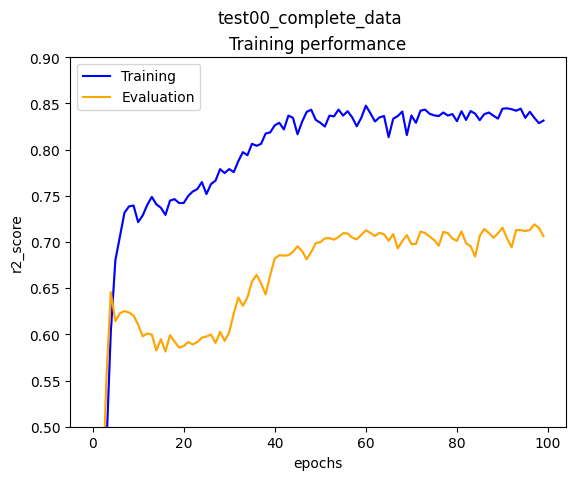

In [10]:
experiment_name = "test00_complete_data"    # train + eval    

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path+ '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

eval_name = ""      

X_train, y_train = df[features], df[target]

model = create_keras_model(nfeatures = len(features), compile = True)

hist = train_model(
    model, X_train, y_train, 
    epochs = n_epochs, 
    output_msr = "r2_score",
    callbacks = [CSVLogger(
        "%s/logs/log_%s_%s.csv" % 
        (experiment_path, eval_name, experiment_name)
        
        #experiment_path + "/logs/" + eval_name + '_log.csv'  , separator =";"
        )]
    )

plot_hist(
    hist.history, title = experiment_name,
    savepath = "%s/out/perf_train_%s_%s.png" % 
    (experiment_path, eval_name, experiment_name)
)


### 2 Stratified K fold (sklearn - considering regions)
---

r2_score  = 0.8377, time = 41.0 sec
r2_score  = 0.8574, time = 39.2 sec
r2_score  = 0.8361, time = 38.0 sec
r2_score  = 0.8338, time = 39.4 sec
r2_score  = 0.8393, time = 37.4 sec


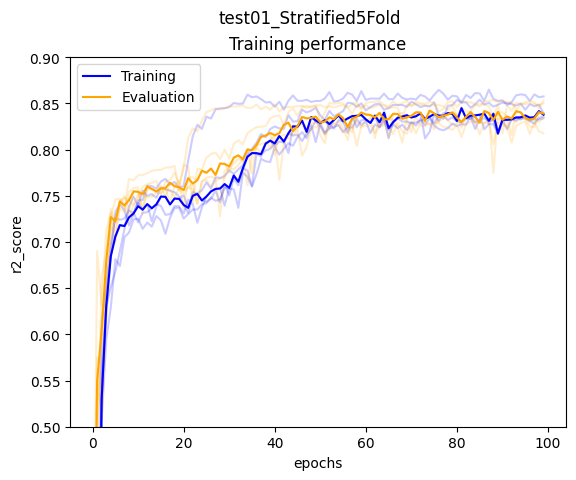

In [11]:
experiment_name = "test01_Stratified5Fold"   # train + eval     

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path+ '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

cv = RepeatedStratifiedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)
regions = df.region.unique()
hists = []

i = 0
for train, _ in cv.split(df, df.region): 
    
    eval_name = "eval" + str(i)
    i += 1
    
    X_train = df.loc[train, features]
    y_train = df.loc[train, target]
    
    model = create_keras_model(nfeatures = len(features), compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s_%s.png" % 
    (experiment_path, eval_name, experiment_name)
)


In [28]:
experiment_name = "test01b_Stratified5Fold_variation"   # train + eval     

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path+ '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

regions = df.region.unique()
hists = []

cv = RepeatedStratifiedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42 + 11 *i)


i = 0
for train, _ in cv.split(df, df.region): 

    eval_name = "eval" + str(i)
    i += 1
    
    X_train = df.loc[train, features]
    y_train = df.loc[train, target]
    
    model = create_keras_model(nfeatures = len(features), compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s_%s.png" % 
    (experiment_path, eval_name, experiment_name)
)


r2_score  = 0.8386, time = 38.9 sec


KeyboardInterrupt: 

### 3 K fold (sklearn)
---

r2_score  = 0.8386, time = 37.1 sec
r2_score  = 0.8401, time = 36.8 sec
r2_score  = 0.8338, time = 37.3 sec
r2_score  = 0.8503, time = 38.0 sec
r2_score  = 0.8305, time = 39.0 sec


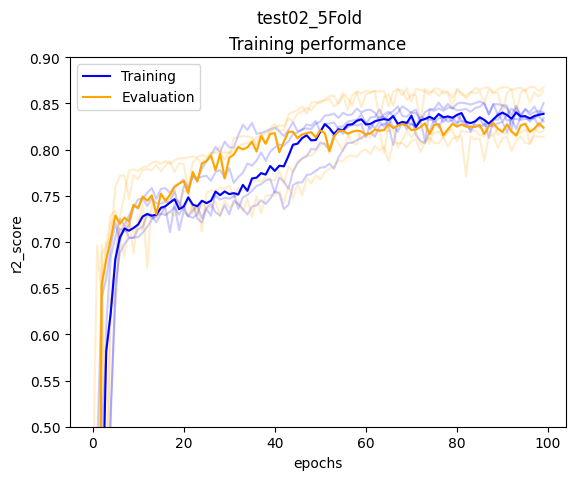

In [12]:
experiment_name = "test02_5Fold"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')


cv = RepeatedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)
hists = []

i = 0
for train, _ in cv.split(df): 
    
    eval_name = "fold" + str(i)
    i += 1
    
    X_train = df.loc[train, features]
    y_train = df.loc[train, target]
    
    model = create_keras_model(nfeatures = len(features), compile = True)

    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)

### 4 80pct sample for training
---

r2_score  = 0.8631, time = 38.4 sec
r2_score  = 0.8404, time = 37.7 sec
r2_score  = 0.8255, time = 38.5 sec
r2_score  = 0.8483, time = 37.3 sec
r2_score  = 0.8424, time = 37.0 sec


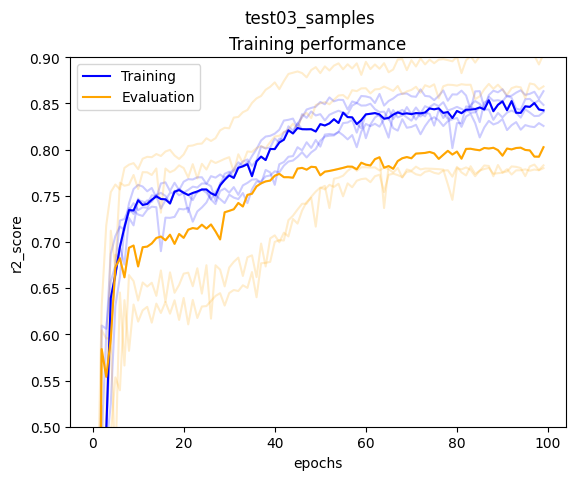

In [13]:
experiment_name = "test03_samples"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train = df.sample(frac = .8, random_state = 42 + 11 * i)
    X_train, y_train = df_train[features], df_train[target]

    
    model = create_keras_model(nfeatures = len(features), compile = True)

    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)


r2_score  = 0.8375, time = 38.3 sec
r2_score  = 0.8343, time = 38.5 sec
r2_score  = 0.8349, time = 37.8 sec
r2_score  = 0.8387, time = 37.8 sec
r2_score  = 0.8476, time = 37.7 sec


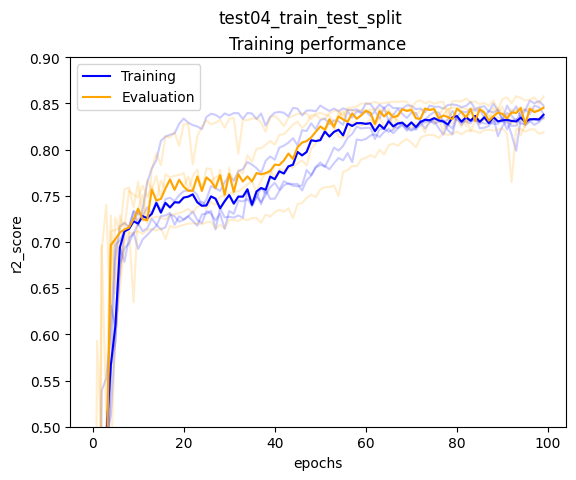

In [17]:
experiment_name = "test04_train_test_split"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train = train_test_split(df, test_size = .2, random_state=42 + 11 * i)[0]
    X_train, y_train = df_train[features], df_train[target]

    
    model = create_keras_model(nfeatures = len(features), compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)


### 5 80ct sample per region combined
---

r2_score  = 0.8249, time = 39.6 sec
r2_score  = 0.8389, time = 38.9 sec
r2_score  = 0.8589, time = 38.0 sec
r2_score  = 0.8464, time = 38.5 sec
r2_score  = 0.8534, time = 37.7 sec


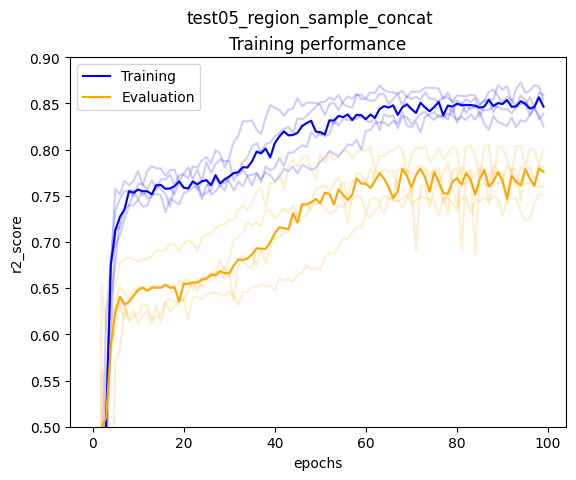

In [18]:
experiment_name = "test05_region_sample_concat"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

regions = df.region.unique()


hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train = pd.concat(
        [df.loc[df.region == region].sample(frac= 0.8, random_state = 42 + i * 11) 
         for region in regions]
    )
    X_train, y_train = df_train[features], df_train[target]

    
    model = create_keras_model(nfeatures = len(features), compile = True)

    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)


### 6 Sklearn train_test_split per region
---

r2_score  = 0.8225, time = 38.4 sec
r2_score  = 0.8588, time = 37.9 sec
r2_score  = 0.8489, time = 37.7 sec
r2_score  = 0.8594, time = 38.1 sec
r2_score  = 0.8438, time = 38.4 sec


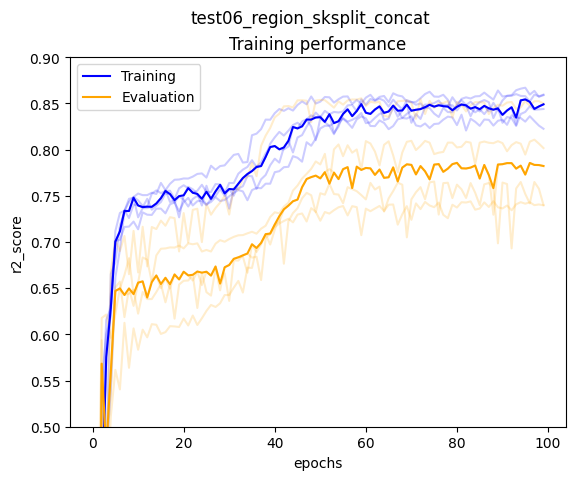

In [19]:
experiment_name = "test06_region_sksplit_concat"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

regions = df.region.unique()


hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train = pd.concat(
        [train_test_split(df.loc[df.region == region], test_size = .2, random_state = 42 + i * 11)[0]
         for region in regions]
    )
    X_train, y_train = df_train[features], df_train[target]

    
    model = create_keras_model(nfeatures = len(features), compile = True)

    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)

### 7 Sklearn 5Fold per region

r2_score  = 0.8431, time = 37.8 sec
r2_score  = 0.8626, time = 43.8 sec
r2_score  = 0.8406, time = 42.7 sec
r2_score  = 0.8656, time = 41.9 sec
r2_score  = 0.8397, time = 41.4 sec


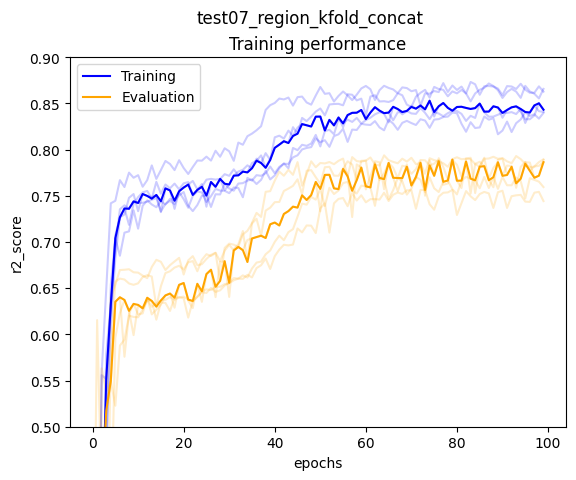

In [20]:
experiment_name = "test07_region_kfold_concat"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')


cv = RepeatedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)


regions = df.region.unique()
hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train_regions = []
    for region in regions:
        df_region = df.loc[df.region == region]
        train, _ = next(itertools.islice(cv.split(df_region), i, None))
        df_train_regions.append(df_region.iloc[train])
    df_train = pd.concat(df_train_regions)
    
    X_train, y_train = df_train[features], df_train[target]

    
    model = create_keras_model(nfeatures = len(features), compile = True)

    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)

### 8 Sklearn 5Fold per region shuffle

r2_score  = 0.8581, time = 41.4 sec
r2_score  = 0.8718, time = 41.0 sec
r2_score  = 0.8140, time = 40.6 sec
r2_score  = 0.8566, time = 39.5 sec
r2_score  = 0.8048, time = 38.7 sec


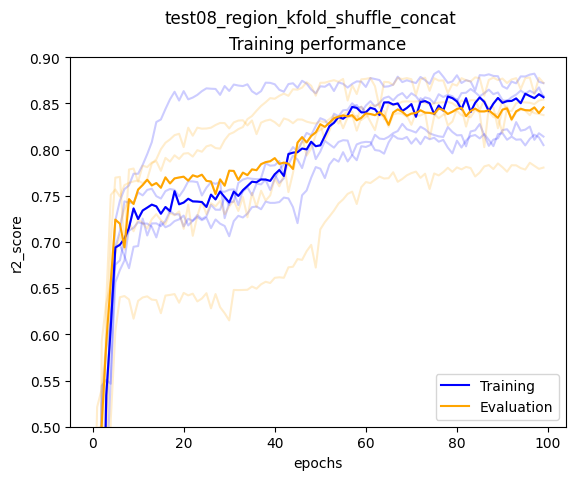

In [21]:
experiment_name = "test08_region_kfold_shuffle_concat"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')


cv = RepeatedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)


regions = df.region.unique()
hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train_regions = []
    for region in regions:
        df_region = df.loc[df.region == region]
        train, _ = next(itertools.islice(cv.split(df_region), i, None))
        df_train_regions.append(df_region.iloc[train])
    df_train = pd.concat(df_train_regions).sample(frac = 1, random_state = 42 + i * 11)
    
    X_train, y_train = df_train[features], df_train[target]

    
    model = create_keras_model(nfeatures = len(features), compile = True)

    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)

### Experiment Template

In [ ]:
# experiment_name = "xxx"        # train + eval

# # logger setup
# experiment_path = log_path + experiment_name
# if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
# if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')


# cv = RepeatedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)
# hists = []

# i = 0
# for train, _ in cv.split(df, df.region): 
    
#     eval_name = "fold" + str(i)
#     i += 1
    
#     X_train = df.loc[train, features]
#     y_train = df.loc[train, target]
    
#     model = create_keras_model(compile = True)
    
#     hist = train_model(
#         model, X_train, y_train, 
#         epochs = n_epochs, 
#         output_msr = "r2_score",
#         callbacks = [CSVLogger(
#             "%s/logs/log_%s_%s.csv" % 
#             (experiment_path, eval_name, experiment_name)
#             )]
#     )
#     hists.append(hist)
    

# plot_hist(
#     [h.history for h in hists], title = experiment_name,
#     savepath = "%s/out/perf_train_%s.png" % 
#     (experiment_path, experiment_name)
# )

## Playground
---

In [ ]:
# # complete data
# X_train, y_train = df[features], df[target]

# model = create_keras_model(compile = True)

# hist = train_model(
#     model, X_train, y_train, 
#     epochs = n_epochs, output_msr = "r2_score")

# plot_hist(hist.history)

In [ ]:
# # samples
# hists = []

# for i in range(3):
#     df_train = df.sample(frac = .8, random_state = 42)

#     X_train, y_train = df_train[features], df_train[target]

#     model = create_keras_model(compile = True)

#     hist = train_model(
#         model, X_train, y_train, 
#         epochs = 100#n_epochs
#         , output_msr = "r2_score")
#     hists.append(hist)

# plot_hist([hist.history for hist in hists])

In [ ]:
# df_train = train_test_split(df, test_size = .2, random_state=42)[0]

# X_train, y_train = df_train[features], df_train[target]

# model = create_keras_model(compile = True)

# hist = train_model(
#     model, X_train, y_train, 
#     epochs = 100#n_epochs
#     , output_msr = "r2_score")

# plot_hist(hist.history)

r2_score  = 0.8287, time = 37.2 sec


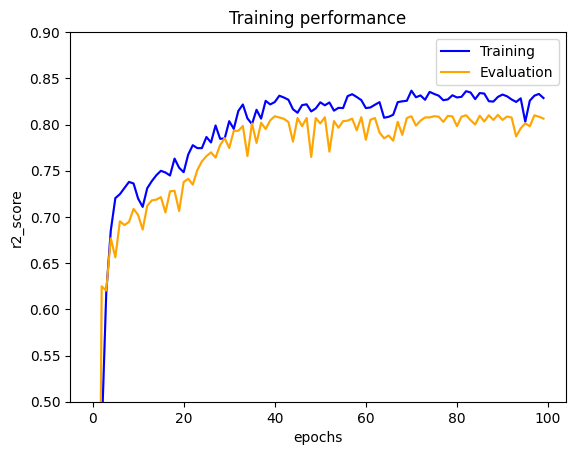

In [ ]:
# df_train = train_test_split(df, test_size = .2, random_state=20)[0]

# X_train, y_train = df_train[features], df_train[target]

# model = create_keras_model(compile = True)

# hist = train_model(
#     model, X_train, y_train, 
#     epochs = 100#n_epochs
#     , output_msr = "r2_score")

# plot_hist(hist.history)

## Analysis
---

In [25]:
# read results 
experiments = [x for x in os.listdir("../output/experiments/05_debug_noreg") if "png" not in x]

logs = []
for ex in experiments:
    #log_files = os.listdir("../output/experiments/04_debug/%s/logs" % ex)
    log_folder = os.path.join("../output/experiments/05_debug_noreg/", ex, "logs")
    log_files = os.listdir(log_folder)
    for log_file in log_files:
        log_path = "../output/experiments/05_debug_noreg/%s/logs/%s" % (ex, log_file)
        logs.append(pd.read_csv(log_path).assign(experiment = ex, file = log_file))
    

In [26]:
# clean results
df_plot = (
    pd.concat(logs)
    .assign(
        r2_rel_error = lambda x: (x.r2_score - x.val_r2_score) / x.val_r2_score,
        experiment = lambda x: x.experiment.str.replace("test.._", ''))
    .groupby(['experiment', 'epoch'], as_index = False)['r2_rel_error'].mean()
)
df_plot['experiment'] = (
    df_plot['experiment']    
    .str.replace("Fold", "Fold (sklearn)")
    .str.replace("train_test_slit", "train_test_split")
    .str.replace("train_test_split", "train_test_split (sklearn)")
)
df_plot.head()

/tmp/ipykernel_51894/1309143529.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  experiment = lambda x: x.experiment.str.replace("test.._", ''))


,experiment,epoch,r2_rel_error
0,5Fold (sklearn),0,-23.123391
1,5Fold (sklearn),1,-0.554049
2,5Fold (sklearn),2,-0.627121
3,5Fold (sklearn),3,-0.102362
4,5Fold (sklearn),4,-0.119649


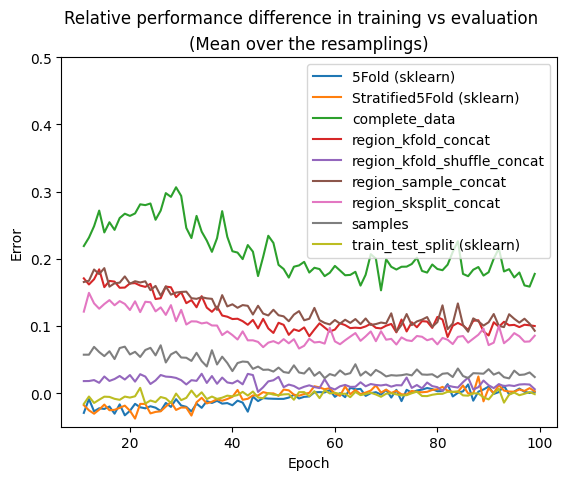

In [27]:
# plot comparison
for ex in df_plot.experiment.unique():
    plt.plot(
        'epoch','r2_rel_error', label = ex, 
        data = df_plot.loc[(df_plot.experiment == ex) & (df_plot.epoch > 10)])
    #df_plot.loc[df_plot.experiment == "test00_complete_data"]
    
plt.ylim([-.05,.5])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.suptitle("Relative performance difference in training vs evaluation")
plt.title("(Mean over the resamplings)")
plt.savefig("../output/experiments/04_debug/" + "comparison.png")
plt.show()


In [ ]:
# for log in logs:
#     plot_hist(log)

## Comparison of the Resampling Splits
---

test02 vs test07

In [ ]:
#test02

cv = RepeatedStratifiedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)
regions = df.region.unique()
resamplings = list(cv.split(df, df.region))

for train, _ in cv.split(df, df.region): 
    
    eval_name = "eval" + str(i)
    
    X_train = df.loc[train, features]
    y_train = df.loc[train, target]

[len(r[0]) / (len(r[1]) + len(r[0])) for r in resamplings]

[0.7997010463378177,
 0.7997010463378177,
 0.7997010463378177,
 0.8004484304932735,
 0.8004484304932735]

In [ ]:
X_train.sample(frac = 1)

,age,sex,bmi,children,smoker,region0,region1,region2,region3
574,0.847826,0.0,0.493274,0.4,0.0,1.0,0.0,0.0,0.0
296,0.021739,1.0,0.315846,0.0,1.0,0.0,0.0,0.0,1.0
1220,0.260870,0.0,0.161017,0.2,0.0,1.0,0.0,0.0,0.0
944,0.956522,1.0,0.644875,0.0,0.0,0.0,0.0,1.0,0.0
1086,0.804348,1.0,0.350148,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
641,0.521739,1.0,0.332257,0.6,1.0,0.0,1.0,0.0,0.0
742,0.760870,1.0,0.488162,0.0,1.0,1.0,0.0,0.0,0.0
256,0.826087,1.0,0.475383,0.0,1.0,0.0,1.0,0.0,0.0
373,0.173913,1.0,0.455744,0.4,1.0,0.0,0.0,0.0,1.0


In [ ]:
#test07

cv = RepeatedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)


regions = df.region.unique()
hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train_regions = []
    for region in regions:
        df_region = df.loc[df.region == region]
        train, _ = next(itertools.islice(cv.split(df_region), i, None))
        df_train_regions.append(df_region.iloc[train])
    df_train = pd.concat(df_train_regions)
    